# __Driver drowsiness detection is a car safety technology which helps prevent accidents caused by the driver getting drowsy. Various studies have suggested that around 20% of all road accidents are fatigue-related, up to 50% on certain roads.__

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
labels = os.listdir(r"E:\driver_drowsiness_detection")

visualize random 1 image

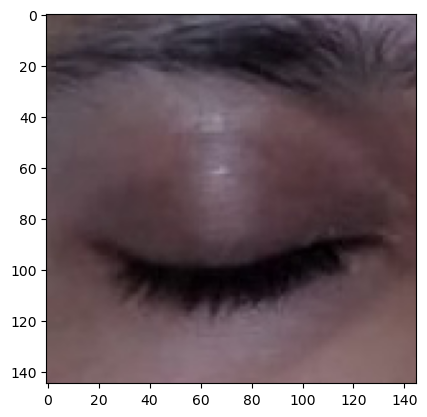

In [3]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"E:\driver_drowsiness_detection\Closed\_0.jpg"))

image array

In [4]:
a = plt.imread("E:/driver_drowsiness_detection/yawn/10.jpg")

image shape

In [5]:
a.shape

(480, 640, 3)

visualize yawn image. 
Here background is unnecessary. we need only face image array

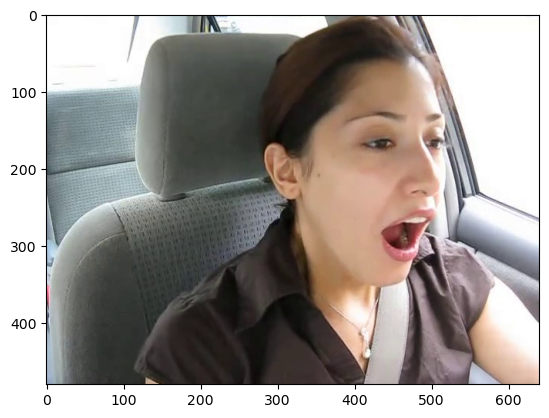

In [6]:
plt.imshow(plt.imread("E:/driver_drowsiness_detection/yawn/2.jpg"))

for yawn and not_yawn. Take only face

In [7]:
def face_for_yawn(direc=r"E:\driver_drowsiness_detection", face_cas_path=r"E:\driver_drowsiness_detection\prediction\haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


for closed and open eye

In [8]:
def get_data(dir_path=r"E:\driver_drowsiness_detection", face_cas=r"E:\driver_drowsiness_detection\prediction\haarcascade_frontalface_default.xml", eye_cas=r"E:\driver_drowsiness_detection\prediction\haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [9]:
data_train = get_data()

2
3


extend data and convert array

In [10]:
# Combine yawning and eye state data
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    
    # Convert lists to numpy arrays before extending
    yaw_no = [np.array(item, dtype=object) for item in yaw_no]
    data = [np.array(item, dtype=object) for item in data]

    # Combine data
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)

new_data = append_data()
print(f"Data shape: {new_data.shape}")

0
1
2
3
Data shape: (1925, 2)


separate label and features

In [11]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [12]:
# reshape the array
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [13]:
# LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [14]:
y = np.array(y)

In [15]:
# train test split
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [16]:
len(X_test)

578

In [17]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [18]:
#Data Augmentation
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

Model

In [19]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.3819 - loss: 1.2537 - val_accuracy: 0.8391 - val_loss: 0.4562
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7833 - loss: 0.5183
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.8479 - loss: 0.3714 - val_accuracy: 0.8564 - val_loss: 0.3514
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.8472 - loss: 0.3482
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.8916 - loss: 0.2440 - val_accuracy: 0.8841 - val_loss: 0.3015
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.8819 - loss: 0.2878
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.8970 - loss: 0.2610 - val_accuracy: 0.8962 - val_loss: 0.2514
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9140 - loss: 0.2195
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8975 - loss: 0.2472 - val_accuracy: 0.9221 - val_loss: 0.2129
Epoch 10/50
43/43 ━━━━━━━━━

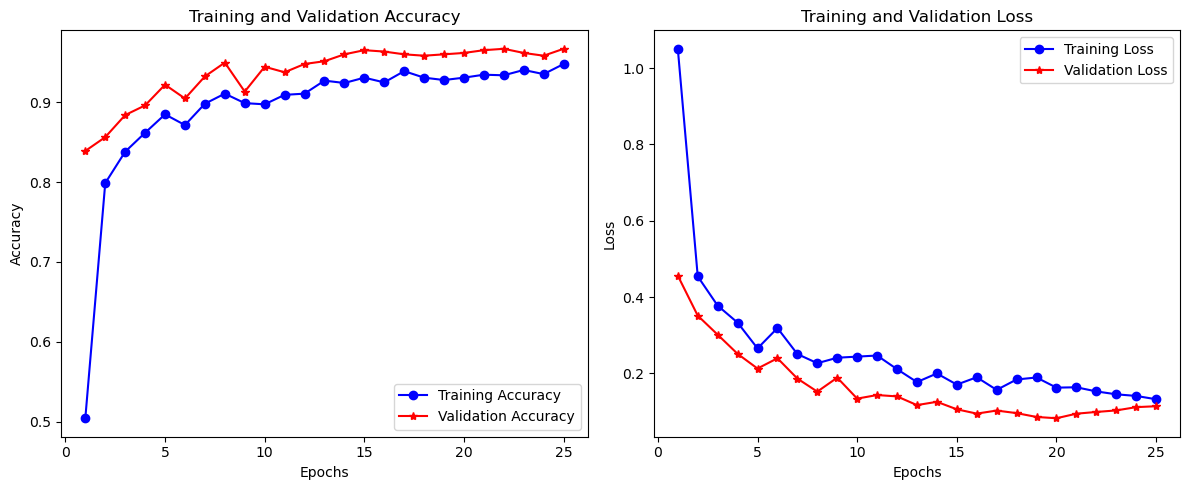

In [23]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the number of epochs to match the length of the validation data
epochs = range(1, min(len(acc), len(val_acc)) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc[:len(epochs)], 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc[:len(epochs)], 'r*-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss[:len(epochs)], 'bo-', label='Training Loss')
plt.plot(epochs, val_loss[:len(epochs)], 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [24]:
model.save("drowiness_model.h5")

prediction

In [26]:
import numpy as np

# Use model.predict() to get the raw class probabilities
predictions = model.predict(X_test)

# Convert the probabilities to class labels using argmax
predicted_classes = np.argmax(predictions, axis=1)

# Now predicted_classes contains the class labels for X_test
print(predicted_classes)

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 510ms/step
[3 3 2 3 1 3 3 2 1 2 3 3 3 2 2 2 3 1 0 3 3 3 2 1 1 2 2 2 2 2 3 3 3 2 1 3 3
 2 1 3 3 3 2 3 2 2 3 3 2 3 3 1 3 1 3 3 2 2 2 0 3 3 1 2 2 3 2 3 2 2 1 3 3 3
 2 0 1 3 1 3 3 0 3 2 2 2 2 1 3 3 2 3 3 3 1 0 3 0 3 3 3 1 3 1 2 3 2 0 2 2 1
 1 2 0 0 3 3 3 2 2 3 3 3 1 1 2 3 3 2 0 3 3 1 3 1 2 3 3 2 1 2 2 2 1 3 3 2 3
 2 0 3 3 3 3 3 1 1 1 3 1 3 2 2 3 2 3 3 2 3 2 3 1 2 0 3 3 2 2 0 2 3 0 2 1 3
 2 3 1 2 0 1 3 2 2 3 3 3 0 3 2 3 0 2 1 0 1 2 3 2 0 3 1 2 2 2 2 1 3 1 1 1 0
 2 3 3 3 3 0 1 2 1 0 3 3 0 3 3 0 3 3 0 1 0 0 3 3 3 3 3 2 3 3 2 3 2 0 2 2 2
 0 3 3 2 2 3 2 2 0 2 3 2 2 2 3 3 3 3 3 0 1 0 3 3 3 3 2 2 1 2 2 2 3 2 0 2 2
 1 3 2 3 1 3 3 1 3 3 0 3 3 2 2 2 1 1 0 3 3 3 3 1 3 0 3 2 2 1 3 3 3 2 3 3 2
 3 3 3 3 2 1 3 2 2 2 1 2 0 3 3 2 3 2 2 2 2 3 2 0 2 1 0 2 2 2 1 3 2 3 3 3 2
 2 2 2 2 2 1 1 3 3 0 3 1 3 2 2 1 0 2 2 3 2 1 3 2 3 3 3 0 0 3 0 2 3 2 2 3 1
 3 3 2 3 3 1 2 3 2 3 1 1 3 2 2 3 1 3 2 2 3 3 2 0 2 0 1 2 2 1 3 2 3 3 3 2 2
 3 2 1 1 2 2 2 2 2 0 2 3 3 2 0 3 2 2 2 2 3 3 0 0 1 3 3 3 2

In [28]:
predictions

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

classification_report

In [29]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [32]:
from sklearn.metrics import classification_report
import numpy as np

# Ensure that predictions are converted to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Assuming y_test contains one-hot encoded labels, convert it to class labels
true_classes = np.argmax(y_test, axis=1)

# Now you can use classification_report
print(classification_report(true_classes, predicted_classes, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.91      0.84      0.88        63
     no_yawn       0.86      0.93      0.90        74
      Closed       0.99      0.97      0.98       215
        Open       0.97      0.99      0.98       226

    accuracy                           0.96       578
   macro avg       0.94      0.93      0.93       578
weighted avg       0.96      0.96      0.96       578



Testing

In [38]:
import cv2
import numpy as np
import tensorflow as tf

# Define the labels for the classes
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145

# Function to prepare the image for prediction
def prepare(filepath, face_cas=r"E:\driver_drowsiness_detection\prediction\haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)  # Read the image using OpenCV
    if img_array is None:
        raise ValueError(f"Image not found at path: {filepath}")
    img_array = img_array / 255.0  # Normalize pixel values to range [0, 1]
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize the image to 145x145
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # Reshape to (1, 145, 145, 3)

# Load the pre-trained model
model_path = "drowiness_model.h5"
try:
    model = tf.keras.models.load_model(model_path)
except Exception as e:
    raise RuntimeError(f"Error loading model from {model_path}: {e}")

# Predict on a new image
image_path = r"E:\driver_drowsiness_detection\prediction\322868_1100-1100x628.jpg"  # Replace with the actual image path
try:
    prepared_image = prepare(image_path)  # Preprocess the image
except ValueError as ve:
    print(ve)
    prepared_image = None

if prepared_image is not None:
    predictions = model.predict(prepared_image)  # Get predictions

    # Convert probabilities to class label
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = labels_new[predicted_class]

    # Output the result
    #print(f"Predicted class: {predicted_label}")

    # Driver status based on prediction
    if predicted_label in ["Open", "no_yawn"]:
        print("Driver is active.")
    elif predicted_label in ["Closed", "yawn"]:
        print("Driver is sleepy.")
else:
    print("No prediction made due to an error in image preparation.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Driver is active.
